Projet Machine Learning DAC - DIY Neural Networks

In [1]:
!pip install tqdm

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import copy
import pandas as pd


Squelette code : hyper-classes Loss et Module

In [3]:
class Loss(object):
    def forward(self, y, yhat):
        pass

    def backward(self, y, yhat):
        pass


class Module(object):
    def __init__(self):
        self._parameters = None
        self._gradient = None

    def zero_grad(self):
        ## Annule gradient
        pass

    def forward(self, X):
        ## Calcule la passe forward
        pass

    def update_parameters(self, gradient_step=1e-3):
        ## Calcule la mise a jour des parametres selon le gradient calcule et le pas de gradient_step
        self._parameters -= gradient_step*self._gradient

    def backward_update_gradient(self, input, delta):
        ## Met a jour la valeur du gradient
        pass

    def backward_delta(self, input, delta):
        ## Calcul la derivee de l'erreur
        pass

Output loss function 1: Mean Square Error

In [4]:
class MSELoss(Loss):
    def forward(self, y, yhat):
        return (y-yhat)**2

    def backward(self, y, yhat):
        return  -2* (y-yhat)


class CELossLogSoftmax(Loss):
    def forward(self, y, y_hat):
        #y en one-hot, y_hat valeurs en R^k (k=nb_classes) avant softmax
        y_hat -= np.max(y_hat, axis=1, keepdims=True)
        log_softmax = y_hat - np.log(np.exp(y_hat).sum(axis=1, keepdims=True))
        loss = -np.sum(y * log_softmax) / y.shape[0]
        return loss

    def backward(self, y, y_hat):
        # ∂L/∂z  =softmax(z)−y avec y en one hot
        y_hat -= np.max(y_hat, axis=1, keepdims=True)
        softmax = np.exp(y_hat) / np.exp(y_hat).sum(axis=1, keepdims=True)
        grad = (softmax - y) / y.shape[0]
        return grad

Linear Module:

In [5]:
class Linear(Module):
    def __init__(self, input, output, weight=None, bias=None):
        super().__init__()
        self._parameters = {}
        self._gradient = {}
        self._output = output
        self._input = input
        if weight is not None:
            self._parameters["w"] = weight
        else:
            self._parameters["w"] = np.random.randn(input, output) * np.sqrt(2/(input+output))
        if bias is not None:
            self._parameters["b"] = bias
        else:
            self._parameters["b"] = np.random.randn(1, output) * np.sqrt(2/(1+output))
        self._gradient["w"] = np.zeros_like(self._parameters["w"])
        self._gradient["b"] = np.zeros_like(self._parameters["b"])


    def forward(self, X):
        assert X.shape[1] == self._input
        return X @ self._parameters["w"] + self._parameters["b"]

    def backward_update_gradient(self, input, delta):
        assert delta.shape[1] == self._output
        assert input.shape[1] == self._input
        self._gradient["w"] +=  input.T @ delta
        self._gradient["b"] += np.sum(delta, axis=0)

    def backward_delta(self, input, delta):
        return np.dot(delta, self._parameters["w"].T)

    def update_parameters(self, gradient_step=0.001):
        self._parameters["w"] -= gradient_step * self._gradient["w"]
        self._parameters["b"] -= gradient_step * self._gradient["b"]

    def zero_grad(self):
        self._gradient["w"] = np.zeros_like(self._parameters["w"])
        self._gradient["b"] = np.zeros_like(self._parameters["b"])

    def is_activation(self):
        return False

Non linear (Activation functions):

In [6]:
class TanH(Module):
    def forward(self, X):
        self.input = X
        self.output = np.tanh(X)
        return self.output

    def update_parameters(self, gradient_step=1e-3):
        pass

    def backward_update_gradient(self, input, delta):
        pass

    def backward_delta(self, input, delta):
        output = np.tanh(input)
        return delta * (1 - output**2)

    def is_activation(self):
        return True

class Sigmoid(Module):
    def forward(self, X):
        X = np.clip(X, -500, 500)
        return np.divide(1, 1+np.exp(-X))


    def update_parameters(self, gradient_step=1e-3):
        pass

    def backward_update_gradient(self, input, delta):
        pass

    def backward_delta(self, input, delta):
        sig = self.forward(input)
        return delta * sig * (1 - sig)

    def is_activation(self):
        return True


class ReLU(Module):
    def forward(self, X):
        zero = np.zeros(X.shape)
        return np.maximum(zero, X)

    def update_parameters(self, gradient_step=1e-3):
        pass

    def backward_update_gradient(self, input, delta):
        pass

    def backward_delta(self, input, delta):
        return delta * (input > 0)

    def is_activation(self):
        return True

Encapsulation: Sequential Module

In [7]:
import copy

class Sequential(Module):
    def __init__(self, *sequence):
        if len(sequence) == 0:
            raise Exception("Empty inialization")
        if len(sequence) == 1 and type(sequence[0]) == list:
            self._layers = copy.deepcopy(list(sequence[0]))
        else:
            self._layers = copy.deepcopy(list(sequence))
        self._forwards = []
        self._deltas = []


    def append(self, module):
        self._layers.append(module)

    def print_layers(self):
        print([layer.__class__.__name__ for layer in self._layers])

    def zero_grad(self):
        for layer in self._layers:
            layer.zero_grad()


    def add(self, module, i=0):
        self._layers.append(module)

    def pop(self, i=-1):
        return self._layers.pop(i)

    def forward(self, X):
        self._inputs = [X]
        out = X
        for module in self._layers:
            self._inputs.append(out)
            out = module.forward(out)
        return out


    def get_output(self):
        return self._forwards[-1][1]

    def update_parameters(self, gradient_step=1e-3):
        for layer in self._layers:
            layer.update_parameters(gradient_step)

    def backward(self, X, delta):
        for module, input_layer in zip(reversed(self._layers), reversed(self._inputs)):
            if not module.is_activation():
                module.backward_update_gradient(input_layer, delta)
            delta = module.backward_delta(input_layer, delta)
        return delta

class Optim(object):
    def __init__(self, model_sequenciel, loss, eps):
        self.model_sequentiel = model_sequenciel
        self.eps = eps
        self.loss = loss
        self.last_forward = None

    def step(self, batch_x, batch_y, eps=None, batch_y_test=None):
        if eps is not None:
            self.eps=eps
        forward = self.model_sequentiel.forward(batch_x)
        self.last_forward = forward
        loss_value = self.loss.forward(batch_y, forward)
        loss_delta = self.loss.backward(batch_y, forward)
        self.model_sequentiel.zero_grad()
        self.model_sequentiel.backward(batch_x, loss_delta)
        self.model_sequentiel.update_parameters(self.eps)
        return loss_value

    def test(self, X_test, y_test):
        pred = self.model_sequentiel.forward(X_test)
        loss = self.loss.forward(y_test, pred)
        return loss, pred

    def SGD(self, X_train, y_train, batch_size, n_iterations, gradient_step= None):
        if gradient_step is None:
            gradient_step = self.eps
        loss_list = []
        pred_list = []
        self.print_layers()
        for _ in range(n_iterations):
            loss_list.append(0)
            pred_list.append(0)
            indices = np.random.permutation(len(X_train))
            X_train_shuffled = X_train[indices]
            y_train_shuffled = y_train[indices]
            for i in range(0, len(X_train), batch_size):
                batch_X = X_train_shuffled[i:i+batch_size]
                batch_y = y_train_shuffled[i:i+batch_size]
                loss = self.step(batch_X,batch_y, gradient_step)
                loss_list[-1] += loss
                pred_list[-1] += self.last_forward
        return loss_list, pred_list

    def print_layers(self):
        self.model_sequentiel.print_layers()


Multiclass Output: logSoftMax && Cross-entropy

In [8]:
def multi_class(X_train, y_train,X_test,y_test, model, loss=CELossLogSoftmax() ,n_iter=1000, eps=1e-2, classes_names=None, titre="Multi Class"):
    #le y_train and y_test sont en one hot encoding
	batch,input,  inter,inter2, n_classes = X_train.shape[0], X_train.shape[1], 10,4, y_train.shape[1]
	loss_list = []
	test_loss_list = []
	loss = CELossLogSoftmax()
	optim = Optim(model, loss,eps)
	for i in tqdm(range(n_iter)):
		loss_list.append(optim.step(X_train,y_train))
		test_loss_list.append(optim.test(X_test,y_test)[0])

	if classes_names is None:
		classes_names = [str(i) for i in range(n_classes)]

	sns.lineplot(loss_list, label='train loss')
	sns.lineplot(test_loss_list, label='test loss')
	plt.xlabel('iterations')
	plt.ylabel('Loss value')
	plt.title(titre)
	plt.show()

	y_pred = optim.test(X_test,y_test)[1] #shape (batch, n_classes)
	cm = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
	sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels= classes_names, yticklabels=classes_names)
	plt.xlabel('Predicted')
	plt.ylabel('True')
	plt.title('Confusion Matrix ' + titre)
	plt.show()
	print(classification_report(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1), target_names=classes_names))



#TESTS: CIFAR-10

In [9]:
import tensorflow as tf

# Load CIFAR-10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize pixel values to [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)


ImportError: Traceback (most recent call last):
  File "c:\Users\yacin\anaconda3\Lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 73, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: Une routine d’initialisation d’une bibliothèque de liens dynamiques (DLL) a échoué.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.

In [ ]:
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(50000, 3072)
(50000, 10)
(10000, 3072)
(10000, 10)


100%|██████████| 100/100 [15:24<00:00,  9.25s/it]


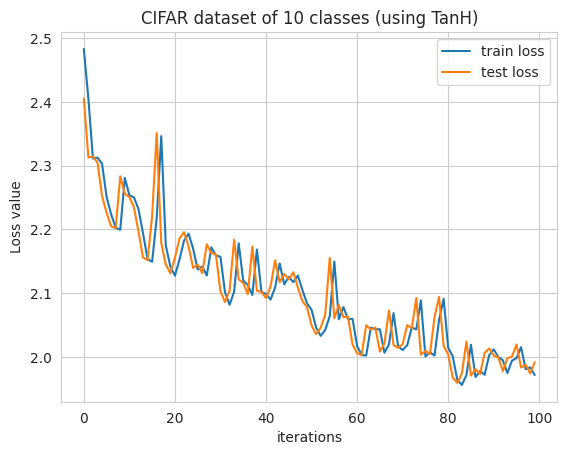

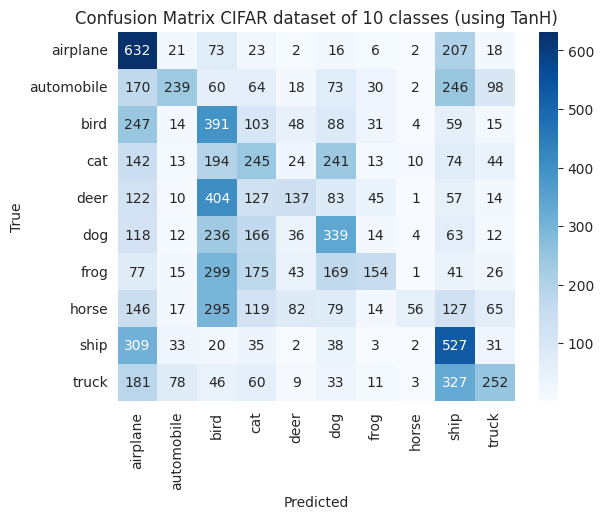

              precision    recall  f1-score   support

    airplane       0.29      0.63      0.40      1000
  automobile       0.53      0.24      0.33      1000
        bird       0.19      0.39      0.26      1000
         cat       0.22      0.24      0.23      1000
        deer       0.34      0.14      0.20      1000
         dog       0.29      0.34      0.31      1000
        frog       0.48      0.15      0.23      1000
       horse       0.66      0.06      0.10      1000
        ship       0.30      0.53      0.39      1000
       truck       0.44      0.25      0.32      1000

    accuracy                           0.30     10000
   macro avg       0.38      0.30      0.28     10000
weighted avg       0.38      0.30      0.28     10000



In [ ]:
model = Sequential([Linear(x_train.shape[1], 176),TanH(),Linear(176, 42), TanH(), Linear(42, 10), TanH()])
multi_class(x_train, y_train,x_test, y_test, model, n_iter=100, eps=1e-1, classes_names=classes, titre='CIFAR dataset of 10 classes (using TanH)')

#ESSAI 2: AUTRE NN

100%|██████████| 100/100 [35:54<00:00, 21.54s/it]


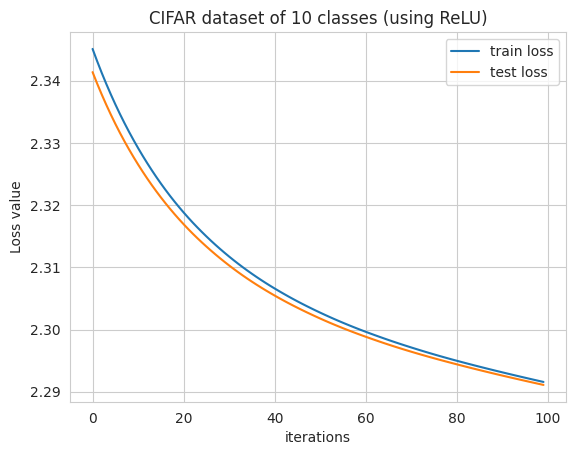

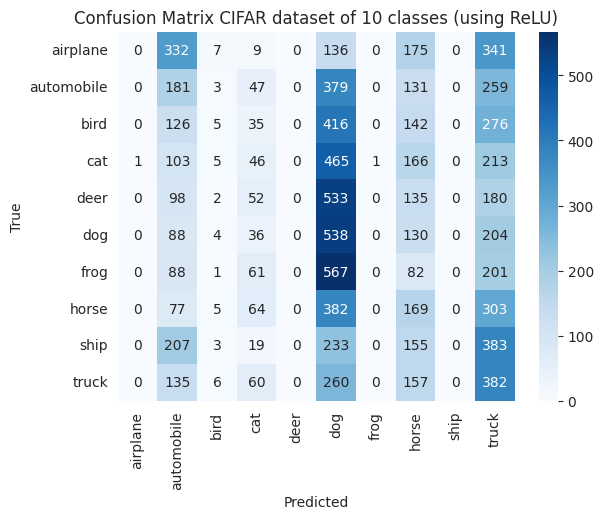

              precision    recall  f1-score   support

    airplane       0.00      0.00      0.00      1000
  automobile       0.13      0.18      0.15      1000
        bird       0.12      0.01      0.01      1000
         cat       0.11      0.05      0.06      1000
        deer       0.00      0.00      0.00      1000
         dog       0.14      0.54      0.22      1000
        frog       0.00      0.00      0.00      1000
       horse       0.12      0.17      0.14      1000
        ship       0.00      0.00      0.00      1000
       truck       0.14      0.38      0.20      1000

    accuracy                           0.13     10000
   macro avg       0.07      0.13      0.08     10000
weighted avg       0.07      0.13      0.08     10000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
model = Sequential([
    Linear(x_train.shape[1], 512),
    ReLU(),
    Linear(512, 256),
    ReLU(),
    Linear(256, 128),
    ReLU(),
    Linear(128, 10),
    ReLU()
])
multi_class(x_train, y_train, x_test, y_test, model, n_iter=100, eps=1e-3, classes_names=classes, titre='CIFAR dataset of 10 classes (using ReLU)')


#ESSAI 3: OPENML CIFAR-10

100%|██████████| 100/100 [17:05<00:00, 10.25s/it]


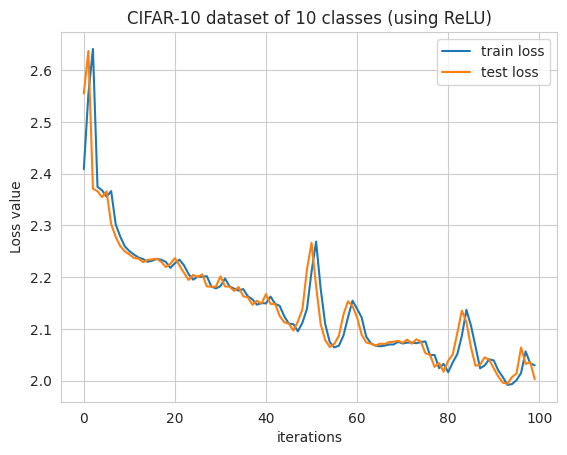

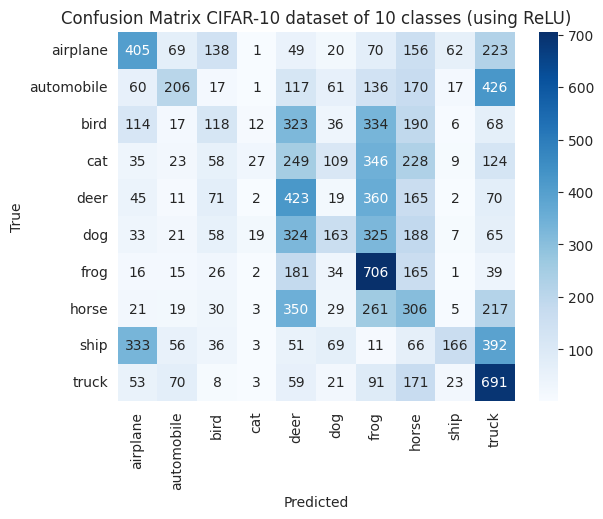

              precision    recall  f1-score   support

    airplane       0.36      0.34      0.35      1193
  automobile       0.41      0.17      0.24      1211
        bird       0.21      0.10      0.13      1218
         cat       0.37      0.02      0.04      1208
        deer       0.20      0.36      0.26      1168
         dog       0.29      0.14      0.18      1203
        frog       0.27      0.60      0.37      1185
       horse       0.17      0.25      0.20      1241
        ship       0.56      0.14      0.22      1183
       truck       0.30      0.58      0.39      1190

    accuracy                           0.27     12000
   macro avg       0.31      0.27      0.24     12000
weighted avg       0.31      0.27      0.24     12000



In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical


# Load CIFAR-10 de OpenML
cifar10 = fetch_openml('CIFAR_10', version=1)

# Split
X = cifar10.data
y = cifar10.target

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

#norm
X_train = X_train.to_numpy().astype('float32') / 255.0
X_test = X_test.to_numpy().astype('float32') / 255.0

model = Sequential([Linear(X_train.shape[1], 176),TanH(),Linear(176, 42), ReLU(), Linear(42, 10)])
multi_class(X_train, y_train,X_test, y_test, model, n_iter=100, eps=1e-1, classes_names=classes, titre='CIFAR-10 dataset of 10 classes (using ReLU)')

#SIMPLIFICATION: BINARY CIFAR-10

100%|██████████| 100/100 [04:32<00:00,  2.73s/it]


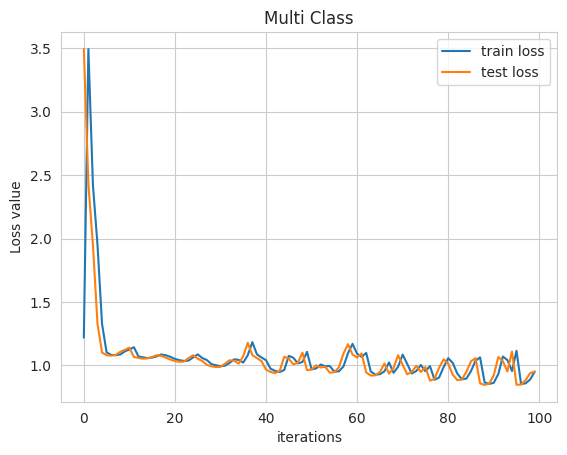

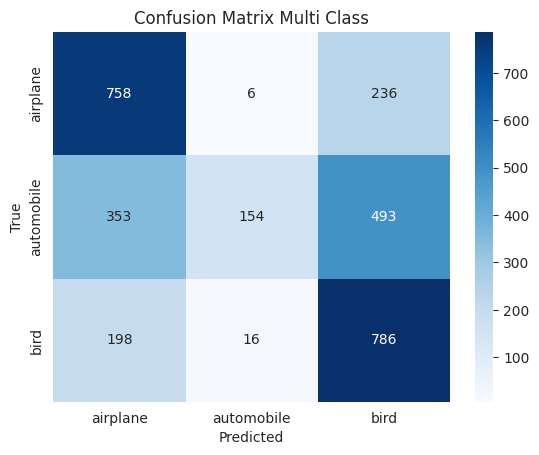

              precision    recall  f1-score   support

    airplane       0.58      0.76      0.66      1000
  automobile       0.88      0.15      0.26      1000
        bird       0.52      0.79      0.63      1000

    accuracy                           0.57      3000
   macro avg       0.66      0.57      0.51      3000
weighted avg       0.66      0.57      0.51      3000



In [ ]:
from tensorflow.keras.datasets import cifar10
import numpy as np
from tensorflow.keras.utils import to_categorical

# Load and select 3 classes (e.g., airplane[0], automobile[1], bird[2])
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
selected_classes = [0, 1, 2]  # Change to any 3 classes (0-9)

# Filter data and convert to one-hot
train_mask = np.isin(y_train.flatten(), selected_classes)
test_mask = np.isin(y_test.flatten(), selected_classes)

X_train_subset = X_train[train_mask].reshape(-1, 32*32*3) / 255.0  # Flatten + normalize
y_train_subset = to_categorical(y_train[train_mask], num_classes=3)  # One-hot
X_test_subset = X_test[test_mask].reshape(-1, 32*32*3) / 255.0
y_test_subset = to_categorical(y_test[test_mask], num_classes=3)

# Your exact model structure (assuming Linear = Dense)
model = Sequential([
    Linear(3072,176),  # Linear layer
    TanH(),
    Linear(176,46),
    ReLU(),
    Linear(46,3)  # 3 outputs (no activation: CELossLogSoftmax handles it)
])

# Train with your multi_class() function
multi_class(
    X_train_subset, y_train_subset,
    X_test_subset, y_test_subset,
    model,
    n_iter=100,
    eps=1e-1,
    classes_names=['airplane', 'automobile', 'bird']  # Custom class names
)

